# Train a new CNN 

### Imports

In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
import random
import time

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow import keras

from tensorflow.python.keras.models import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
#from tensorflow.keras.activations import linear, sigmoid, relu

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dropout, RandomFlip, RandomRotation, RandomBrightness

from keras_tuner.tuners import BayesianOptimization

from tensorflow.keras.optimizers import Adam

2023-02-22 11:01:32.619097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vigitia/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib:/home/vigitia/ros2_galactic/ros2-linux/opt/yaml_cpp_vendor/lib:/home/vigitia/ros2_galactic/ros2-linux/opt/rviz_ogre_vendor/lib:/home/vigitia/ros2_galactic/ros2-linux/lib
2023-02-22 11:01:32.619113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.__version__

'2.9.1'

### Constants

In [37]:
IMG_SIZE = 48
MIN_BRIGHTNESS_PREDICTION = 50

PARENT_DIRECTORY = 'training_images/'
FOLDER_NAME = '2023-02-22'

In [52]:
DRAW_PATHS = []
HOVER_PATHS = []

target_folder = os.path.join(PARENT_DIRECTORY, FOLDER_NAME)

subfolders = (next(os.walk(target_folder))[1])

for subfolder_name in subfolders:
    if 'draw' in subfolder_name:
        DRAW_PATHS.append(os.path.join(PARENT_DIRECTORY, FOLDER_NAME, subfolder_name))
    elif 'hover' in subfolder_name:
        HOVER_PATHS.append(os.path.join(PARENT_DIRECTORY, FOLDER_NAME, subfolder_name))
    else:
        print('ERROR: Malformed folder name')
        
print('All folders with "DRAW"  images: ', DRAW_PATHS)
print('All folders with "HOVER" images: ', HOVER_PATHS)

All folders with "DRAW"  images:  ['training_images/2023-02-22/draw_0_600_18']
All folders with "HOVER" images:  ['training_images/2023-02-22/hover_far_0_600_18', 'training_images/2023-02-22/hover_close_0_600_18']


### Helper functions

In [53]:
def read_images_mono(path):
    
    files = os.listdir(path)
    files = [file for file in files if file[-4:] == ".png"]
    
    print('Read {} files from "{}"'.format(len(files), path))
    
    images = []
    coords = []
    
    size = IMG_SIZE
    
    skip_count = 0
    
    for file in tqdm(files):
        try:
            image = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            if image.shape == (size, size) and np.max(image) > MIN_BRIGHTNESS_PREDICTION: #  and '681_597' not in file and '46_565' not in file:
                
                # Remove Background "noise" 
                MAX_EXPECTED_BACKGROUND_BRIGHTNESS = 10
                image[image < MAX_EXPECTED_BACKGROUND_BRIGHTNESS] = 0
                
                images.append(image)
            else:
                # print(image.shape, np.max(image))
                skip_count += 1
            
        except OSError:
            pass
    
    print('Skipped:', skip_count)
    return images, coords

In [54]:
def data_augmentation(images):
    result = []
    for img in images:
        result.append(img)
        result.append(cv2.flip(img, flipCode=0))
        for i in range(3):  # TODO: CHECK IF 4 is needed here
            tmp = cv2.rotate(img, i)
            for b in range(10, 11):
                tmp2 = np.clip(tmp * (b / 10), 0, 255)
                result.append(tmp2)
                result.append(cv2.flip(tmp2, flipCode=0))
    return result

In [55]:
data_augmentation_new = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    # RandomRotation(0.25),
    RandomBrightness(0.1),
])

### Read in images and create additional images via Data Augmentation

In [56]:
images_draw = []
images_hover = []

for p in DRAW_PATHS:
    images_draw += read_images_mono(p)[0]
    
for p in HOVER_PATHS:
    images_hover += read_images_mono(p)[0]

random.shuffle(images_draw)
random.shuffle(images_hover)
    
images_draw_test = []
images_hover_test = []
images_draw_train = []
images_hover_train = []

for i, img in enumerate(images_draw):
    if i % 5 == 0:
        images_draw_test.append(img)
    else:
        images_draw_train.append(img)
        
for i, img in enumerate(images_hover):
    if i % 5 == 0:
        images_hover_test.append(img)
    else:
        images_hover_train.append(img)
    
images_draw_train = data_augmentation(images_draw_train)
images_hover_train = data_augmentation(images_hover_train)
images_train = images_draw_train + images_hover_train
labels_train = [0] * len(images_draw_train) + [1] * len(images_hover_train)

images_test = images_draw_test + images_hover_test
labels_test = [0] * len(images_draw_test) + [1] * len(images_hover_test)

print(len(images_hover_train))
print(len(images_draw_train))
print(len(images_train))
print(len(labels_train))
print(len(images_test))
print(len(labels_test))

Read 1000 files from "training_images/2023-02-22/draw_0_600_18"


/tmp/ipykernel_19534/1135696556.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/1000 [00:00<?, ?it/s]

Skipped: 0
Read 1000 files from "training_images/2023-02-22/hover_far_0_600_18"


  0%|          | 0/1000 [00:00<?, ?it/s]

Skipped: 0
Read 1000 files from "training_images/2023-02-22/hover_close_0_600_18"


  0%|          | 0/1000 [00:00<?, ?it/s]

Skipped: 0
12800
6400
19200
19200
600
600


8466 19200
1
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  51. 202. 255.  92.  12.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]


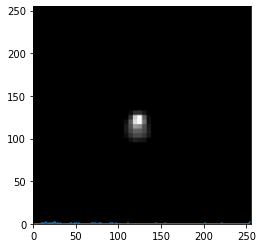

In [57]:
randi = random.randint(0, len(images_train))
image = images_train[randi]

print(randi, len(images_train))
print(labels_train[randi])
print(images_train[randi][24])
# plt.imshow(image, 'gray')

from sklearn.cluster import KMeans
from collections import Counter


histogram, bin_edges = np.histogram(image, bins=256, range=(1, 255))
#plt.figure()
#plt.figure(figsize=(10,10))
#plt.title("Grayscale Histogram")
#plt.xlabel("grayscale value")
#plt.ylabel("pixel count")
#plt.xlim([0, 255])

fig, ax = plt.subplots()
plt.xlim([0, 255])
im = ax.imshow(cv2.resize(image, (255, 255), interpolation = cv2.INTER_AREA), 'gray', extent=[0, 255, 0, 255])


plt.plot(bin_edges[0:-1], histogram)
plt.show()

### Preview Data

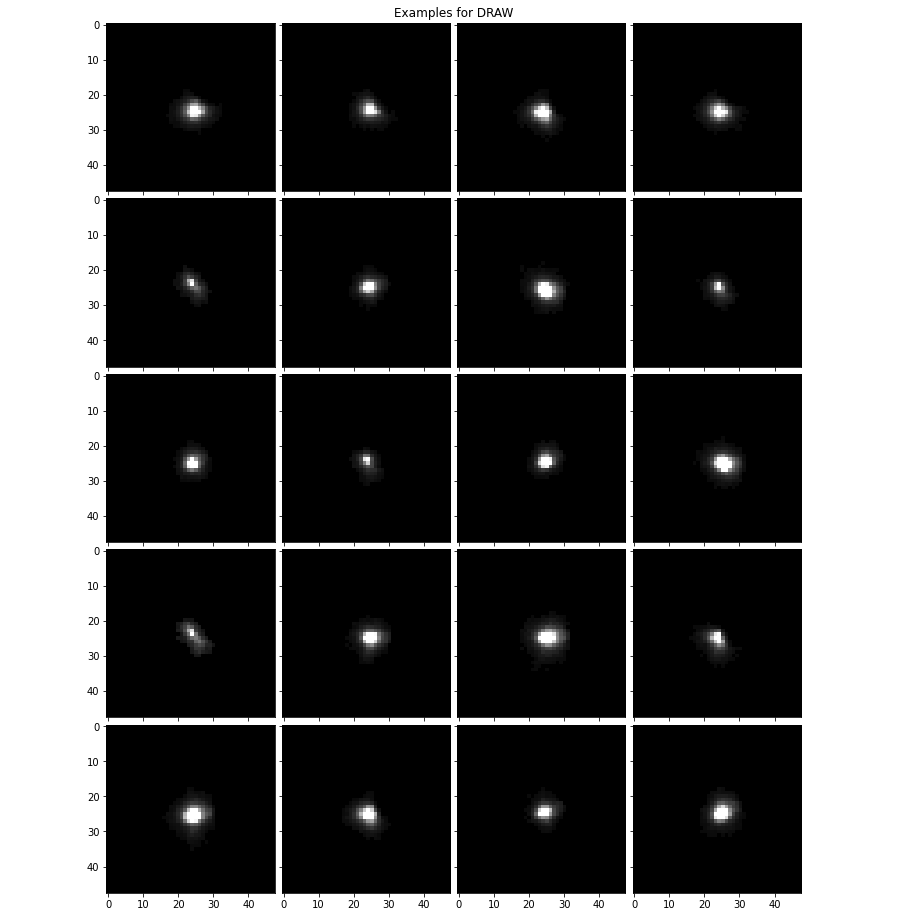

In [58]:
ROWS = 4
COLUMS = 5


image_list = []
for i in range(ROWS*COLUMS):
    
    image = random.sample(images_draw_test, 1)[0]
    image_list.append(image)
    # histogram, bin_edges = np.histogram(image, bins=256, range=(1, 255))
    # image_list.append([histogram, bin_edges, image])


fig = plt.figure(figsize=(16, 16))
plt.title('Examples for DRAW')
plt.axis('off')
grid = ImageGrid(fig, 111,  nrows_ncols=(COLUMS, ROWS), axes_pad=0.1,)

for ax, im in zip(grid, image_list):
    # Iterating over the grid returns the Axes.
    # ax.plot(im[1][0:-1], im[0])
    ax.imshow(im, 'gray')
    
    

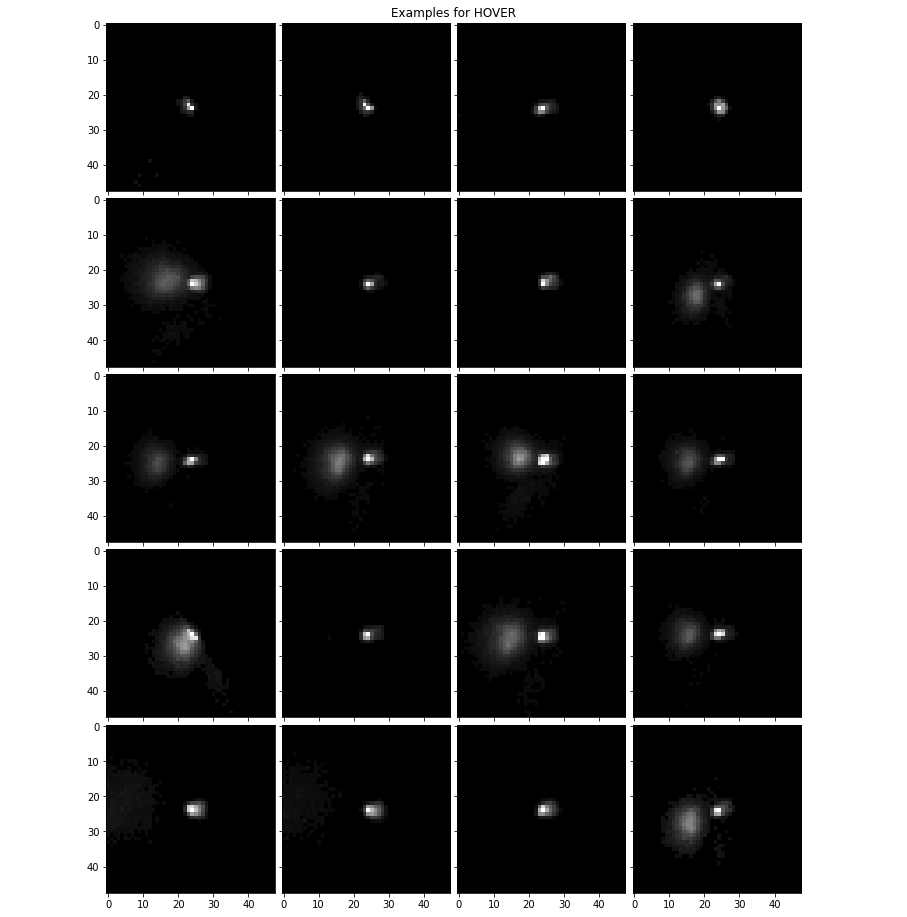

In [59]:
ROWS = 4
COLUMS = 5


image_list = []
for i in range(ROWS*COLUMS):
    image_list.append(random.sample(images_hover_test, 1)[0])


fig = plt.figure(figsize=(16, 16))
plt.title('Examples for HOVER')
plt.axis('off')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(COLUMS, ROWS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, image_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')

### Prepare Training and Validation Data

In [60]:
train_X = np.array(images_train)
train_Y = np.array(labels_train)
test_X = np.array(images_test)
test_Y = np.array(labels_test)

print('Training data shape : ', train_X.shape, train_Y.shape)

train_X = train_X.astype('float32')
train_X = train_X / 255.

test_X = test_X.astype('float32')
test_X = test_X / 255.

train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

train_label = train_Y_one_hot

valid_X = test_X
valid_label = test_Y_one_hot

#train_X, _, train_label, _ = train_test_split(train_X, train_Y_one_hot, test_size=0.0, random_state=13)
#valid_X, _, train_label, _ = train_test_split(test_X, test_Y_one_hot, test_size=1.0, random_state=13)

train_X = train_X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
valid_X = test_X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

unique, counts = np.unique(valid_label, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(train_label, return_counts=True)

print(dict(zip(unique, counts)))

Training data shape :  (19200, 48, 48) (19200,)
(19200, 48, 48, 1) (600, 48, 48, 1) (19200, 2) (600, 2)
{0.0: 600, 1.0: 600}
{0.0: 19200, 1.0: 19200}


In [47]:
l = [0, 0]
for i in valid_label:
    #print(i)
    l[int(np.argmax(i))] += 1
l

[600, 1199]

### Start Training

In [61]:
#Settings

# batch 64
# epoch 1
# conv linear

batch_size = 128
epochs = 1
num_classes = 2
activation = 'relu'
activation_conv = 'linear' #LeakyReLU
layer_count = 5
num_neurons = 128

#for epochs in range(1, 7):
    #print(f'+++++ EPOCHS: {epochs} +++++')
#Define model structure
model = Sequential()

#model.add(data_augmentation_new)
model.add(Conv2D(64, kernel_size=(3, 1),activation=activation_conv,input_shape=(IMG_SIZE,IMG_SIZE,1),padding='same'))
model.add(Conv2D(64, (1, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(32, (3, 1), activation=activation_conv,padding='same'))
model.add(Conv2D(32, (1, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))                 
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())

# trial and error: linear performs much better than ReLU and sigmoid
for i in range(layer_count-1):
    model.add(Dense(num_neurons, activation=activation))
model.add(Dropout(0.2))

model.add(Dense(num_neurons, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(128, activation='linear'))
#model.add(Dense(128, activation='linear'))

# classifier
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

In [65]:
history = model.fit(
    train_X, 
    train_label, 
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[reduce_lr]
)

150/150 [==============================] - 30s 202ms/step - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.0095 - val_accuracy: 0.9983


In [66]:
# TODO: Create a plot from these values
loss = print(history.history['loss'])
val_loss = print(history.history['val_loss'])
accuracy = print(history.history['accuracy'])
val_accuracy = print(history.history['val_accuracy'])

[0.03639254719018936]
[0.009455631487071514]
[0.9888020753860474]
[0.9983333349227905]


### Save the Model

In [68]:
MODEL_NAME = 'model_2023_003'

if MODEL_NAME in next(os.walk('.'))[1]:
    print('Warning: There already exists a model called "{}"'.format(MODEL_NAME))
    print('Make sure you want to overwrite it before it gets saved!')
else:
    model.save(MODEL_NAME)

Make sure you want to overwrite it before it gets saved!


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 48, 48, 64)        256       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 48, 48, 64)        12352     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 24, 24, 64)        0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 24, 24, 32)        6176      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 24, 24, 32)        3104      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 12, 12, 32)        0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 12, 12, 32)        9

# Hyperparameter Optimization

In [10]:
def build_model(hp):
    dense_layer_count = hp.Int('dense_layer_count', min_value=1, max_value=5, step=1)
    dense_layer_neurons = hp.Int('dense_layer_neurons', min_value=32, max_value=128, step=32)
    dense_layer_activation = hp.Choice('dense_layer_activation', values=['linear', 'sigmoid', 'relu'])
    conv_layer_count = hp.Int('conv_layer_count', min_value=1, max_value=5, step=1)
    conv_layer_activation = hp.Choice('conv_layer_activation', values=['linear', 'sigmoid', 'relu'])
    conv_kernel_split = hp.Choice('conv_kernel_split', values=[True, False])
    conv_kernel_size = hp.Int('conv_kernel_size', min_value=3, max_value=7, step=2)
    conv_kernel_stride = hp.Choice('conv_stride', values=[1, 2, 3, 4, 5])
    conv_kernel_count = hp.Int('conv_kernel_count', min_value=16, max_value=64, step=16)
    #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = hp.Choice('optimizer', values=['Adam', 'Adamax', 'Nadam'])
    conv_dropout = hp.Choice('conv_dropout', values=[True, False])
    dense_dropout = hp.Choice('dense_dropout', values=[True, False])

    #for epochs in range(1, 7):
        #print(f'+++++ EPOCHS: {epochs} +++++')
    #Define model structure
    model = tf.keras.models.Sequential()

    stride = (conv_kernel_stride, conv_kernel_stride)
    
    #model.add(data_augmentation_new)
    if conv_kernel_split:
        model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, 1), activation=conv_layer_activation, input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same', strides=stride))
        model.add(Conv2D(conv_kernel_count, (1, conv_kernel_size), activation=conv_layer_activation, padding='same', strides=stride))
    else:
        model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, conv_kernel_size), activation=conv_layer_activation, input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same', strides=stride))
    
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    for i in range(0, conv_layer_count - 1):
        if conv_kernel_split:
            model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, 1), activation=conv_layer_activation, padding='same', strides=stride))
            model.add(Conv2D(conv_kernel_count, (1, conv_kernel_size), activation=conv_layer_activation, padding='same', strides=stride))
        else:
            model.add(Conv2D(conv_kernel_count, kernel_size=(conv_kernel_size, conv_kernel_size), activation=conv_layer_activation, padding='same', strides=stride))
        model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    if conv_dropout:
        model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    # trial and error: linear performs much better than ReLU and sigmoid
    for i in range(dense_layer_count):
        if i == dense_layer_count - 1 and dense_layer_count > 1:
            if dense_dropout:
                model.add(Dropout(0.2))
        model.add(Dense(dense_layer_neurons, activation=dense_layer_activation))

    # classifier
    model.add(Dense(2, activation='softmax'))
    
    #optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
    #optimizer = keras.optimizers.Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)

    model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001) # patience 1, min_lr 0.00005
stop_early = EarlyStopping(monitor='val_loss', patience=1)

tuner = BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=30
)

history = tuner.search(train_X, train_label, batch_size=128, epochs=15, validation_data=(valid_X, valid_label), callbacks=[reduce_lr, stop_early])

Trial 24 Complete [00h 29m 26s]
val_accuracy: 0.9942891001701355

Best val_accuracy So Far: 0.9954706430435181
Total elapsed time: 12h 37m 35s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
1                 |1                 |dense_layer_count
96                |96                |dense_layer_neurons
linear            |linear            |dense_layer_activation
5                 |5                 |conv_layer_count
linear            |linear            |conv_layer_activation
1                 |0                 |conv_kernel_split
7                 |7                 |conv_kernel_size
1                 |2                 |conv_stride
64                |64                |conv_kernel_count
Adam              |Adamax            |optimizer
0                 |0                 |conv_dropout
0                 |0                 |dense_dropout

Epoch 1/15
 595/2857 [=====>........................] - ETA: 15:53 - loss: 0.2269 - accuracy: 0.9105

KeyboardInterrupt: 

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001) # patience 1, min_lr 0.00005
stop_early = EarlyStopping(monitor='val_loss', patience=2)

tuner_32_new = BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=30,
    project_name='batch_32_new'
)

history_32_new = tuner_32_new.search(train_X, train_label, batch_size=32, epochs=20, validation_data=(valid_X, valid_label), callbacks=[reduce_lr, stop_early])

Trial 13 Complete [00h 42m 28s]
val_accuracy: 0.9959487915039062

Best val_accuracy So Far: 0.9965159893035889
Total elapsed time: 04h 48m 39s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
1                 |1                 |dense_layer_count
64                |96                |dense_layer_neurons
relu              |relu              |dense_layer_activation
4                 |1                 |conv_layer_count
relu              |relu              |conv_layer_activation
1                 |1                 |conv_kernel_split
7                 |7                 |conv_kernel_size
1                 |1                 |conv_stride
16                |16                |conv_kernel_count
Adam              |Adam              |optimizer
1                 |1                 |conv_dropout
1                 |1                 |dense_dropout

Epoch 1/20
  674/12342 [>.............................] - ETA: 4:17 - loss: 0.3309 - accuracy: 0.8561

KeyboardInterrupt: 

In [14]:
#Settings

# batch 64
# epoch 1
# conv linear

batch_size = 32
epochs = 20
num_classes = 2
activation = 'relu'
activation_conv = 'relu' #LeakyReLU
layer_count = 1
num_neurons = 96

#for epochs in range(1, 7):
    #print(f'+++++ EPOCHS: {epochs} +++++')
#Define model structure
model = Sequential()

#model.add(data_augmentation_new)
model.add(Conv2D(16, kernel_size=(7, 1),activation=activation_conv,input_shape=(IMG_SIZE,IMG_SIZE,1),padding='same'))
model.add(Conv2D(16, (1, 7), activation=activation_conv,padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Dropout(0.2))
#model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))                 
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())

model.add(Dense(num_neurons, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(128, activation='linear'))
#model.add(Dense(128, activation='linear'))

# classifier
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001) # patience 1, min_lr 0.00005
stop_early = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(
    train_X, 
    train_label, 
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
12342/12342 [==============================] - 208s 17ms/step - loss: 0.0950 - accuracy: 0.9681 - val_loss: 0.0615 - val_accuracy: 0.9795
Epoch 2/20
12342/12342 [==============================] - 208s 17ms/step - loss: 0.0470 - accuracy: 0.9860 - val_loss: 0.0348 - val_accuracy: 0.9883
Epoch 3/20
12342/12342 [==============================] - 209s 17ms/step - loss: 0.0343 - accuracy: 0.9895 - val_loss: 0.0229 - val_accuracy: 0.9936
Epoch 4/20
12342/12342 [==============================] - 211s 17ms/step - loss: 0.0270 - accuracy: 0.9917 - val_loss: 0.0263 - val_accuracy: 0.9930
Epoch 5/20
12342/12342 [==============================] - 207s 17ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.0166 - val_accuracy: 0.9955
Epoch 6/20
12342/12342 [==============================] - 205s 17ms/step - loss: 0.0138 - accuracy: 0.9957 - val_loss: 0.0176 - val_accuracy: 0.9958
Epoch 7/20
12342/12342 [==============================] - 208s 17ms/step - loss: 0.0117 - accuracy: 0.9963

In [16]:
MODEL_NAME = 'model_optimized_1'

if MODEL_NAME in next(os.walk('.'))[1]:
    print('Warning: There already exists a model called "{}"'.format(MODEL_NAME))
    print('Make sure you want to overwrite it before it gets saved!')
else:
    model.save(MODEL_NAME)

INFO:tensorflow:Assets written to: model_optimized_1/assets


INFO:tensorflow:Assets written to: model_optimized_1/assets



---------------------------------------------


In [246]:
model = keras.models.load_model('model_new_projector_4')


1/1 [==============================] - 0s 12ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
--
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 14ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
--
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
--
1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 10ms/step
[[0. 1.]]
1/1 [==============================] - 0s 14ms/step
[[0. 1.]]

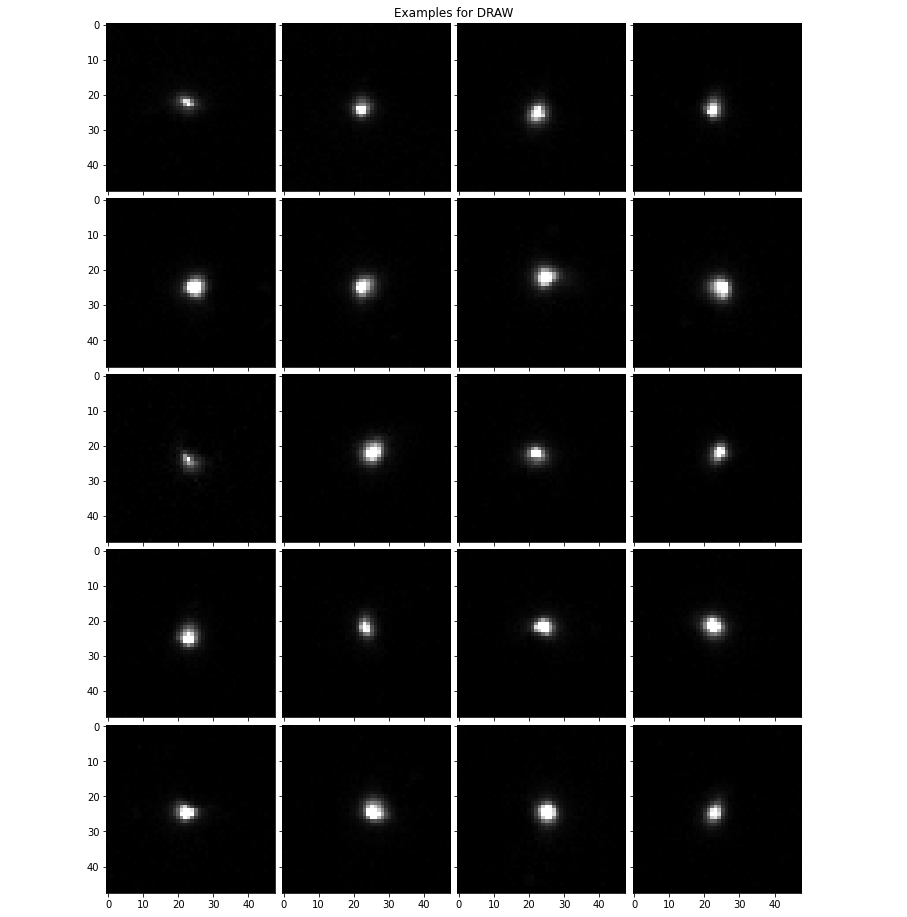

In [248]:
ROWS = 4
COLUMS = 5


image_list = []
for i in range(ROWS*COLUMS):
    image_list.append(random.sample(images_draw, 1)[0])


for i, image in enumerate(image_list):
    prediction = model.predict(image.reshape(-1, IMG_SIZE, IMG_SIZE, 1))
    print(prediction)
    if (i + 1) % 4 == 0:
        print('--')
    

fig = plt.figure(figsize=(16, 16))
plt.title('Examples for DRAW')
plt.axis('off')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(COLUMS, ROWS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, image_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')

In [ ]:
import cv2
import os
import random
from matplotlib import pyplot as plt

STATES = ['draw', 'hover', 'undefined']

MODEL_PATH = 'model_new_projector_4'
keras.backend.clear_session()
#keras_lite_model = LiteModel.from_keras_model(keras.models.load_model(MODEL_PATH))
keras_lite_model = keras.models.load_model(MODEL_PATH)
print(os.getcwd())
draw_path = '../out3/2022-08-02/draw_1_400_18/'
image_paths_draw = os.listdir(draw_path)
hover_path = 'out3/2022-08-02/hover_close_1_400_18/'
image_paths_hover = os.listdir(hover_path)
correct = 0
num_draw = 0
correct_draw = 0
num_hover = 0
correct_hover = 0
brightnesses = []

draw_path_temp = []
for filename in image_paths_draw:
    if '681_597' not in filename:
        draw_path_temp.append(filename)
    else:
        print('Oh no')

image_paths_draw = draw_path_temp

too_dark = 0
for image in image_paths_draw:
    img = cv2.imread(draw_path + random.sample(image_paths_draw, 1)[0], cv2.IMREAD_GRAYSCALE)
    brightnesses.append(np.max(img))
    if np.max(img) < 50:
        too_dark +=1

print('TOO DARK:', too_dark/len(image_paths_draw))

for i in range(1000):
    condition = 'hover' if int(random.random() * 1000) % 2 == 0 else 'draw'
    # condition = 'draw'
    if condition == 'draw':
        num_draw += 1
        img = cv2.imread(draw_path + random.sample(image_paths_draw, 1)[0], cv2.IMREAD_GRAYSCALE)
        # print('Max', np.max(img))
    else:
        num_hover += 1
        img = cv2.imread(hover_path + random.sample(image_paths_hover, 1)[0], cv2.IMREAD_GRAYSCALE)
    #cv2.imshow('test', img)
    #cv2.waitKey(0)
    img = img.reshape(-1, 48, 48, 1)
    print(condition)
    prediction = keras_lite_model.predict(img)
    print(prediction)
    state = STATES[np.argmax(prediction)]
    if condition == state:
        if condition == 'draw':
            correct_draw += 1
        if condition == 'hover':
            correct_hover += 1
        correct +=1
    # print(condition, state)
print('----')
print('Correct total:', correct, '%')
print('Correct Draw:', correct_draw, ' / ', num_draw) #int((correct_draw/num_draw)*100), '%')
print('Correct Hover:', correct_hover, ' / ', num_hover)  # int((correct_draw/num_draw)*100), '%')
plt.boxplot(brightnesses)#, np.ones(len(brightnesses), np.uint8))
plt.scatter(np.ones(len(brightnesses), np.uint8), brightnesses, alpha=0.2)
plt.show()
